In [1]:
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
from tensorflow_model_optimization.sparsity.keras import strip_pruning
from sklearn.metrics import accuracy_score
from optparse import OptionParser
from tensorflow import keras
from sklearn import metrics
import tensorflow as tf
import pandas as pd
import numpy as np
# import plotting
import hls4ml
import shap
import sys
import os

np.random.seed(77)

import matplotlib.pyplot as plt
import mplhep
plt.style.use(mplhep.style.CMS)

/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/hls4ml_instruct_cnn/hls4ml/converters/__init__.py:15: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


In [2]:
options = {
    'v'         : '8',
    'date'      : '2022_09_10',
    'inTag'     : '_lTauPtCut18',
    'caloClNxM' : '5x9',
    'sparsity'  : 0.5
}

In [3]:
indir = '/data_CMS/cms/motta/Phase2L1T/'+options['date']+'_v'+options['v']+'/TauCNNIdentifier'+options['caloClNxM']+'Training'+options['inTag']

N = int(options['caloClNxM'].split('x')[0])
M = int(options['caloClNxM'].split('x')[1])

sparsityTag = str(options['sparsity']).split('.')[0]+'p'+str(options['sparsity']).split('.')[1]

In [4]:
X1 = np.load(indir+'/X_CNN_'+options['caloClNxM']+'_forEvaluator.npz')['arr_0']
X2 = np.load(indir+'/X_Dense_'+options['caloClNxM']+'_forEvaluator.npz')['arr_0']
Y  = np.load(indir+'/Y_'+options['caloClNxM']+'_forEvaluator.npz')['arr_0']

X1 = np.float32(X1)
X2 = np.float32(X2)
Y = np.float32(Y)

X1_reduced = X1[:3000]
X2_reduced = X2[:3000]
Y_reduced = Y[:3000]

In [5]:
# load non-pruned models
TauIdentifierModel = keras.models.load_model('/data_CMS/cms/motta/Phase2L1T/'+options['date']+'_v'+options['v']+'/TauCNNIdentifier'+options['caloClNxM']+'Training'+options['inTag']+'/TauCNNIdentifier', compile=False)
TauQIdentifierModel = keras.models.load_model('/data_CMS/cms/motta/Phase2L1T/'+options['date']+'_v'+options['v']+'/TauCNNIdentifier'+options['caloClNxM']+'Training'+options['inTag']+'/TauQCNNIdentifier', compile=False)

2022-09-20 18:52:53.159587: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /grid_mnt/opt__exp_soft/llr/python/3.9.9/lib/python3.9/site-packages/cv2/../../lib64:/opt/exp_soft/llr/python/3.9.9/lib/vtk:/opt/exp_soft/llr/python/3.9.9/lib:/usr/lib64/classads:/usr/lib64:/usr/lib
2022-09-20 18:52:53.159630: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-09-20 18:52:53.160050: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) t

Interpreting Model
Topology:
Layer name: TowerClusterImage, layer type: Input
Layer name: CNNlayer1, layer type: Conv2D
  -> Activation (linear), layer name: CNNlayer1
Layer name: BNlayer1, layer type: BatchNormalization
Layer name: reluCNNlayer1, layer type: Activation
Layer name: CNNlayer2, layer type: MaxPooling2D
Layer name: CNNlayer3, layer type: Conv2D
  -> Activation (linear), layer name: CNNlayer3
Layer name: BNlayer2, layer type: BatchNormalization
Layer name: reluCNNlayer3, layer type: Activation
Layer name: TowerClusterPosition, layer type: Input
Layer name: middleMan, layer type: Concatenate
Layer name: DNNlayer1, layer type: Dense
  -> Activation (linear), layer name: DNNlayer1
Layer name: reluDNNlayer1, layer type: Activation
Layer name: DNNlayer2, layer type: Dense
  -> Activation (linear), layer name: DNNlayer2
Layer name: reluDNNlayer2, layer type: Activation
Layer name: DNNout, layer type: Dense
  -> Activation (linear), layer name: DNNout
Layer name: sigmoidDNNout, l

Profiling weights (final / after optimization)
Profiling activations (before optimization)
   TowerClusterImage
   CNNlayer1
   BNlayer1
   reluCNNlayer1
   CNNlayer2
   CNNlayer3
   BNlayer2
   reluCNNlayer3
   CNNflatened
   TowerClusterPosition
   middleMan
   DNNlayer1
   reluDNNlayer1
   DNNlayer2
   reluDNNlayer2
   DNNout
   sigmoidDNNout
Profiling activations (final / after optimization)
Recompiling myproject with tracing
Writing HLS project
Done
   CNNlayer1
   CNNlayer1_linear
   BNlayer1
   reluCNNlayer1
   CNNlayer2
   CNNlayer3
   CNNlayer3_linear
   BNlayer2
   reluCNNlayer3
   middleMan
   DNNlayer1
   DNNlayer1_linear
   reluDNNlayer1
   DNNlayer2
   DNNlayer2_linear
   reluDNNlayer2
   DNNout
   DNNout_linear
   sigmoidDNNout
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


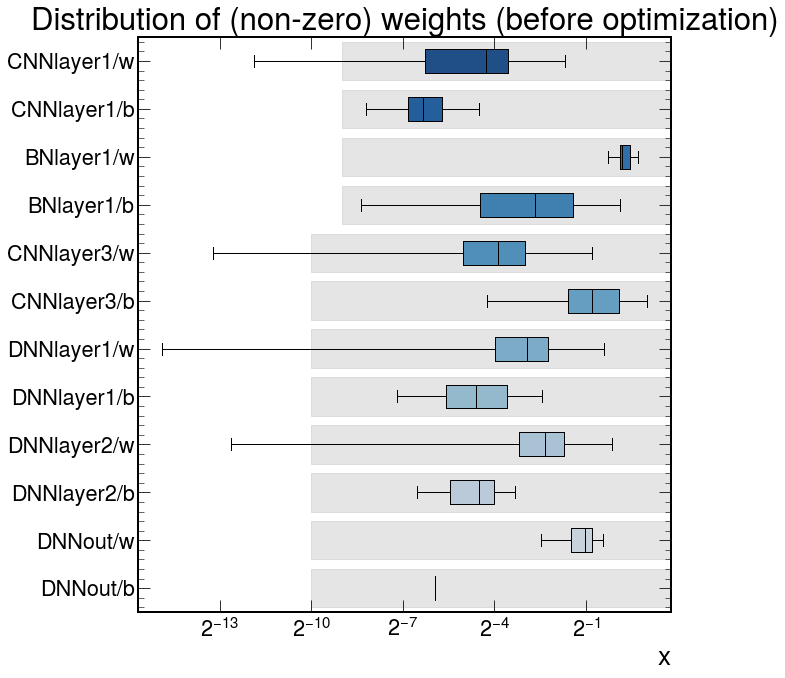

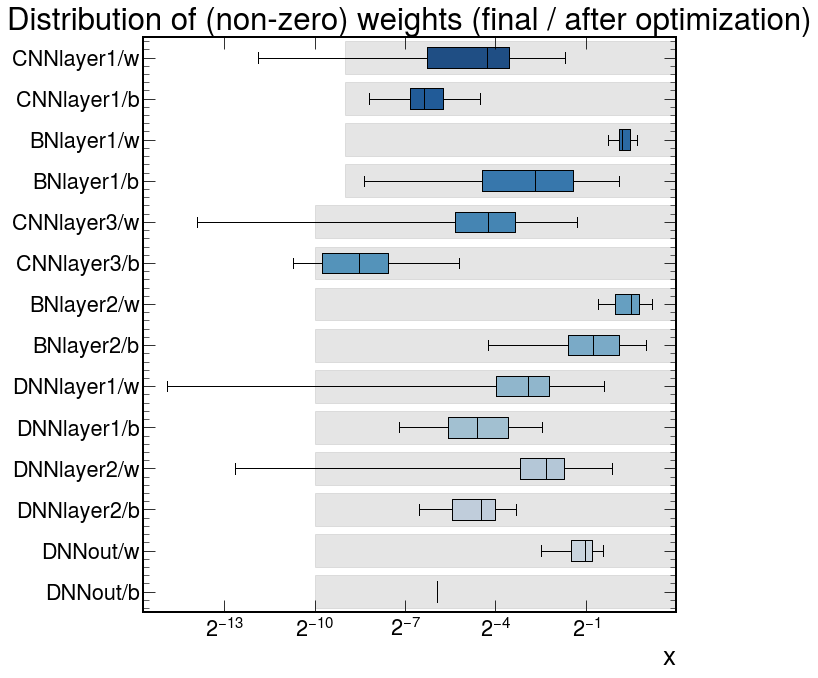

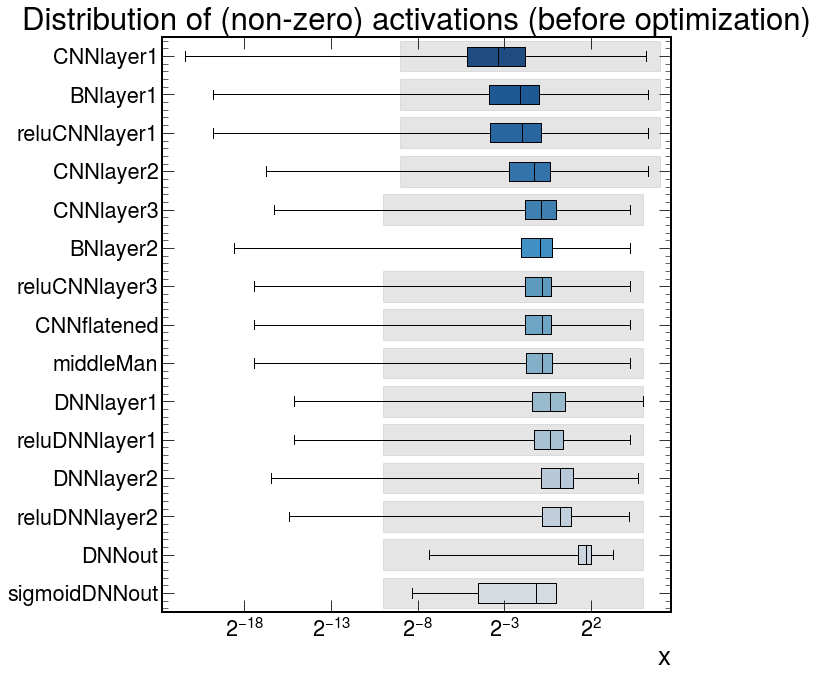

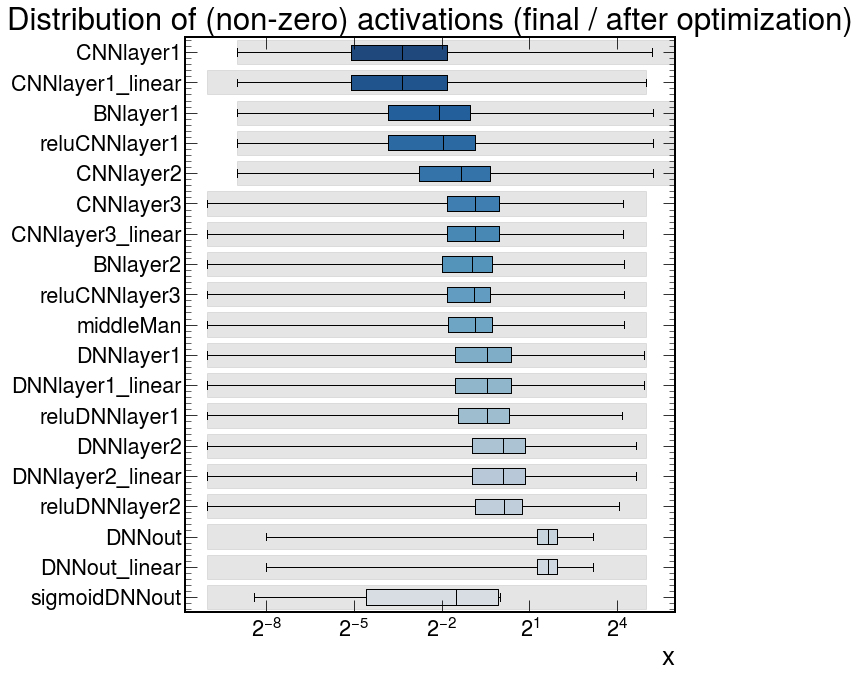

In [6]:
############################## Pass non-quantized model through hls4ml ##############################

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=['Activation'],
                                                                                  rounding_mode='AP_RND',
                                                                                  saturation_mode='AP_SAT')

# baseline model
hls_config = hls4ml.utils.config_from_keras_model(TauIdentifierModel, granularity='name')
hls_config['Model']['Precision'] = 'ap_fixed<16,6>'
hls_config['Model']['ReuseFactor'] = 1
for Layer in hls_config['LayerName'].keys():
    hls_config['LayerName'][Layer]['Strategy'] = 'Latency'
    hls_config['LayerName'][Layer]['ReuseFactor'] = 1
    hls_config['LayerName'][Layer]['Trace'] = True
hls_config['LayerName']['TowerClusterImage']['Precision'] = 'ap_fixed<16,9>'
hls_config['LayerName']['CNNlayer1']['Precision'] = 'ap_fixed<16,7>'
hls_config['LayerName']['BNlayer1']['Precision'] = 'ap_fixed<16,7>'
hls_config['LayerName']['reluCNNlayer1']['Precision'] = 'ap_fixed<16,7>'
hls_config['LayerName']['CNNlayer2']['Precision'] = 'ap_fixed<16,7>'
hls_config['LayerName']['sigmoidDNNout']['Strategy'] = 'Stable'
# plotting.print_dict(hls_config)
print(hls_config)

cfg = hls4ml.converters.create_config(backend='Vivado')
cfg['IOType']     = 'io_parallel' # Must set this if using CNNs!
cfg['HLSConfig']  = hls_config
cfg['KerasModel'] = TauIdentifierModel
cfg['OutputDir']  = 'TauIdentifierModel/'
cfg['Part']       = 'xcvu13p-fhgb2104-2L-e'
cfg['XilinxPart'] = 'xcvu13p-fhgb2104-2L-e'

hls_TauIdentifierModel = hls4ml.converters.keras_to_hls(cfg)

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=[])
hls_TauIdentifierModel.compile()

hls4ml.model.profiling.numerical(model=TauIdentifierModel, hls_model=hls_TauIdentifierModel, X=[X1_reduced,X2_reduced])
# hls4ml.model.profiling.numerical(model=TauIdentifierModel, hls_model=hls_TauIdentifierModel)
hls4ml.utils.plot_model(hls_TauIdentifierModel, show_shapes=True, show_precision=True, to_file=None)

Interpreting Model
Topology:
Layer name: TowerClusterImage, layer type: Input
Layer name: CNNpBNlayer1, layer type: QConv2DBatchnorm
  -> Activation (linear), layer name: CNNpBNlayer1
Layer name: reluCNNlayer1, layer type: QActivation
  -> Activation (quantized_relu(6,0)), layer name: reluCNNlayer1
Layer name: CNNlayer2, layer type: MaxPooling2D
Layer name: CNNpBNlayer3, layer type: QConv2DBatchnorm
  -> Activation (linear), layer name: CNNpBNlayer3
Layer name: reluCNNlayer3, layer type: QActivation
  -> Activation (quantized_relu(6,0)), layer name: reluCNNlayer3
Layer name: TowerClusterPosition, layer type: Input
Layer name: middleMan, layer type: Concatenate
Layer name: DNNlayer1, layer type: QDense
  -> Activation (linear), layer name: DNNlayer1
Layer name: reluDNNlayer1, layer type: QActivation
  -> Activation (quantized_relu(6,0)), layer name: reluDNNlayer1
Layer name: DNNlayer2, layer type: QDense
  -> Activation (linear), layer name: DNNlayer2
Layer name: reluDNNlayer2, layer ty

   reluCNNlayer1
   CNNlayer2
   CNNpBNlayer3
   reluCNNlayer3
   CNNflatened
   TowerClusterPosition
   middleMan
   DNNlayer1
   reluDNNlayer1
   DNNlayer2
   reluDNNlayer2
   DNNout
   sigmoidDNNout
Profiling activations (final / after optimization)
Recompiling myproject with tracing
Writing HLS project
Done
   CNNpBNlayer1
   CNNpBNlayer1_linear
   reluCNNlayer1
   CNNlayer2
   CNNpBNlayer3
   CNNpBNlayer3_linear
   reluCNNlayer3
   middleMan
   DNNlayer1
   DNNlayer1_linear
   reluDNNlayer1
   DNNlayer2
   DNNlayer2_linear
   reluDNNlayer2
   DNNout
   DNNout_linear
   sigmoidDNNout
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


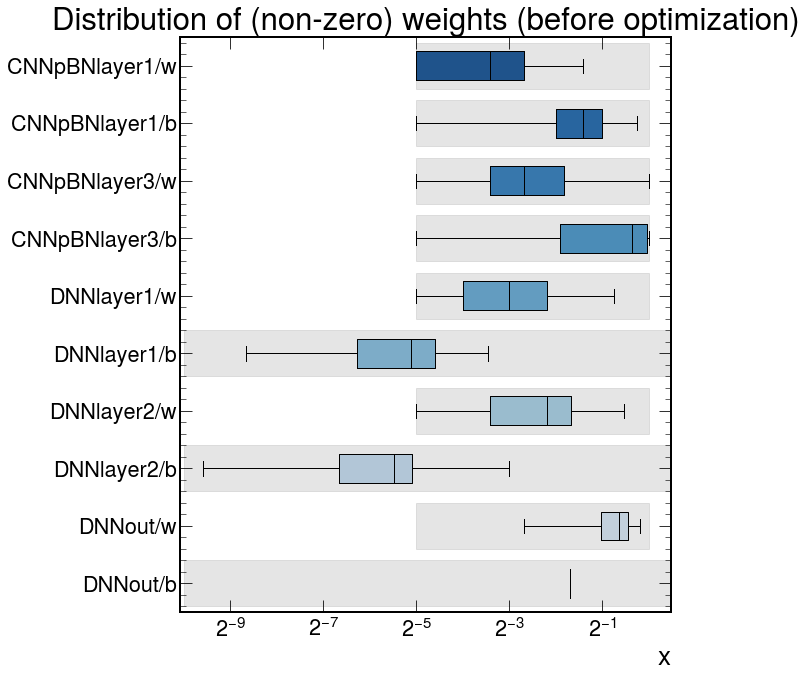

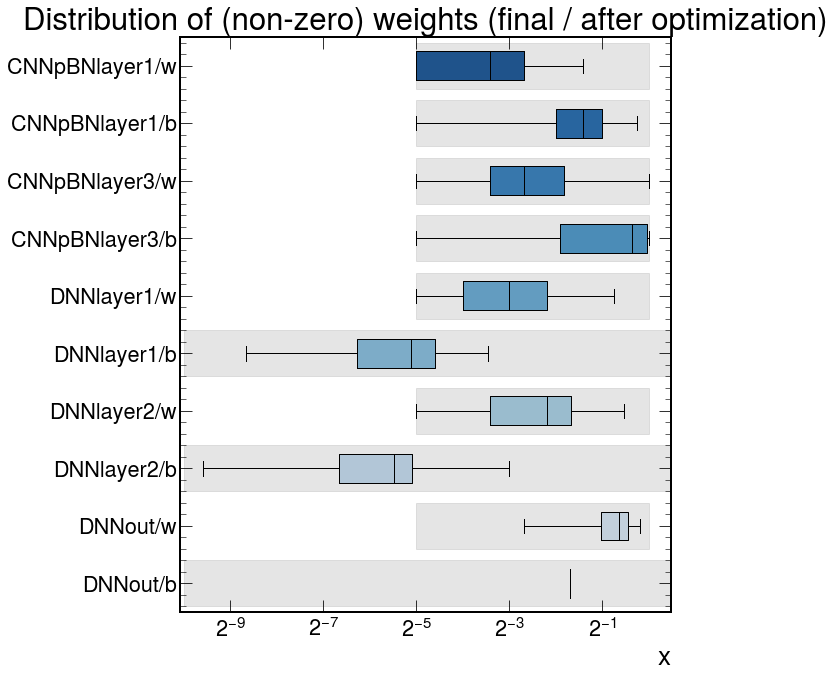

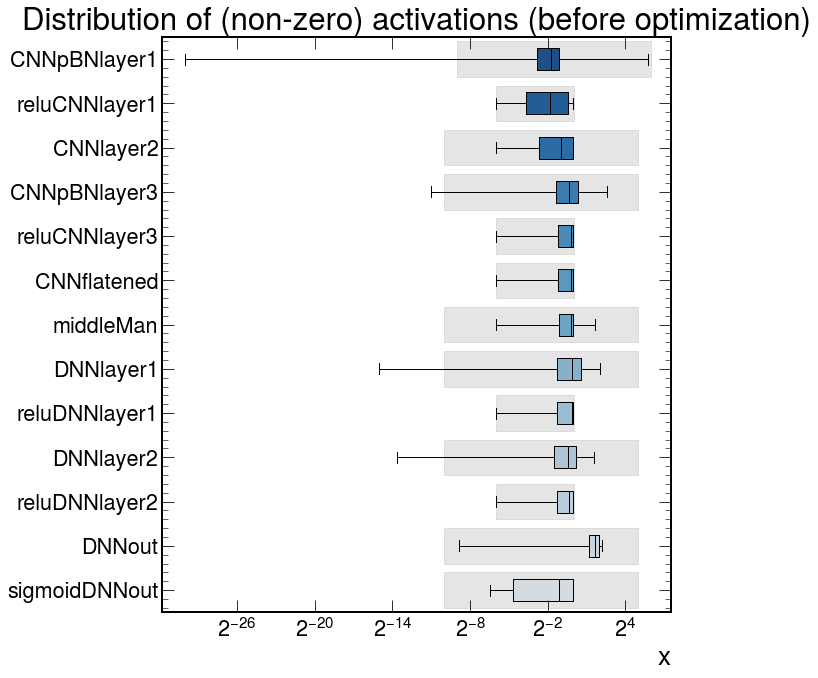

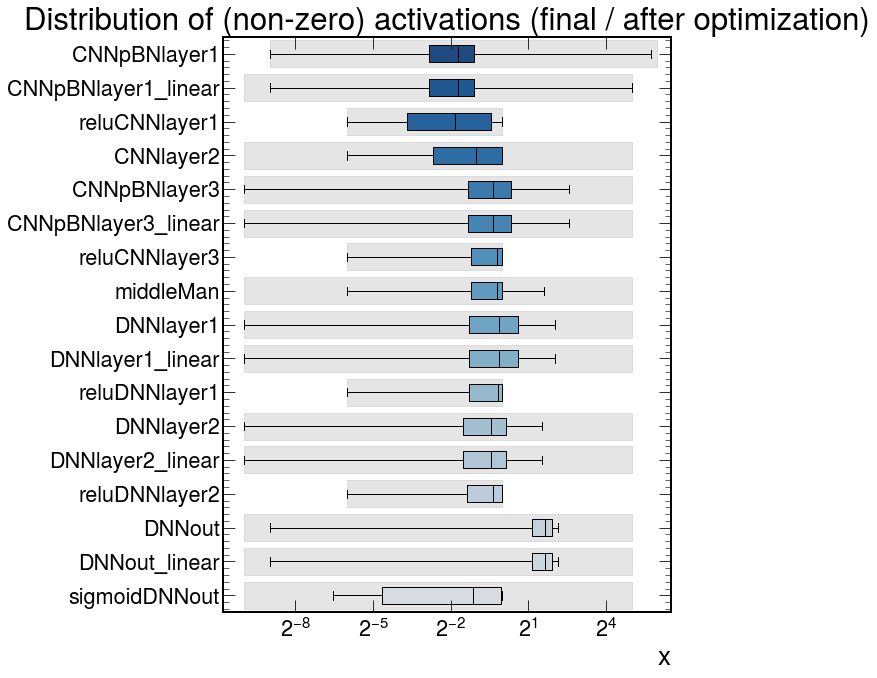

In [7]:
# ############################## Pass quantized model through hls4ml ##############################

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=['Activation'],
                                                                                  rounding_mode='AP_RND',
                                                                                  saturation_mode='AP_SAT')

Qhls_config = hls4ml.utils.config_from_keras_model(TauQIdentifierModel, granularity='name')
Qhls_config['Model']['ReuseFactor'] = 1
Qhls_config['Model']['Precision'] = 'ap_fixed<16,6>'
for Layer in Qhls_config['LayerName'].keys():
    Qhls_config['LayerName'][Layer]['Strategy'] = 'Latency'
    Qhls_config['LayerName'][Layer]['ReuseFactor'] = 1
    Qhls_config['LayerName'][Layer]['Trace'] = True
Qhls_config['LayerName']['TowerClusterImage']['Precision'] = 'ap_fixed<16,9>'
Qhls_config['LayerName']['CNNpBNlayer1']['Precision'] = 'ap_fixed<16,7>'
Qhls_config['LayerName']['sigmoidDNNout']['Strategy'] = 'Stable'
# plotting.print_dict(Qhls_config)
print(hls_config)

cfg_q = hls4ml.converters.create_config(backend='Vivado')
cfg_q['IOType']     = 'io_parallel' # Must set this if using CNNs!
cfg_q['HLSConfig']  = Qhls_config
cfg_q['KerasModel'] = TauQIdentifierModel
cfg_q['OutputDir']  = 'TauQIdentifierModel/'
cfg_q['XilinxPart'] = 'xcvu13p-fhgb2104-2L-e'

hls_TauQIdentifierModel = hls4ml.converters.keras_to_hls(cfg_q)

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=[])
hls_TauQIdentifierModel.compile()

hls4ml.model.profiling.numerical(model=TauQIdentifierModel, hls_model=hls_TauQIdentifierModel, X=[X1_reduced,X2_reduced])
hls4ml.utils.plot_model(hls_TauQIdentifierModel, show_shapes=True, show_precision=True, to_file=None)

In [8]:
y_predict        = TauIdentifierModel.predict([X1, X2])
y_predict_hls4ml = hls_TauIdentifierModel.predict([X1, X2])

In [9]:
y_predict_q        = TauQIdentifierModel.predict([X1, X2])
y_predict_hls4ml_q = hls_TauQIdentifierModel.predict([X1, X2])

Accuracy Keras:  1.0
Accuracy hls4ml: 1.0
Accuracy Keras:  1.0
Accuracy hls4ml: 1.0


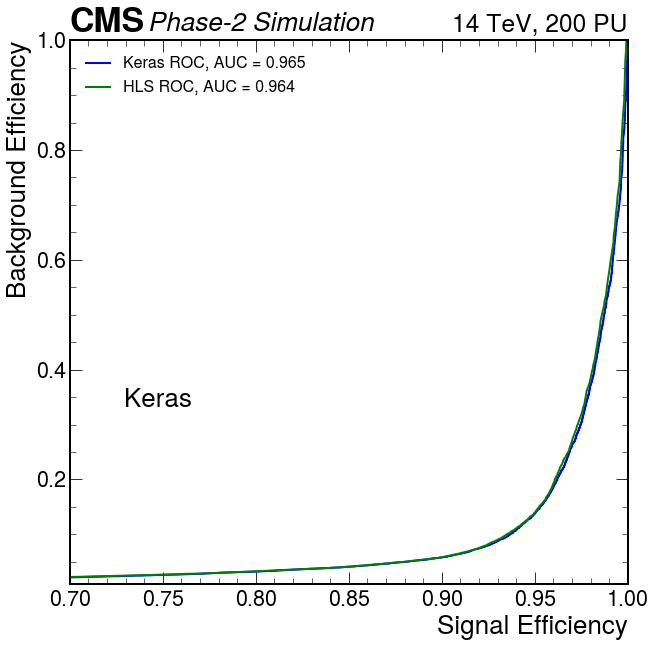

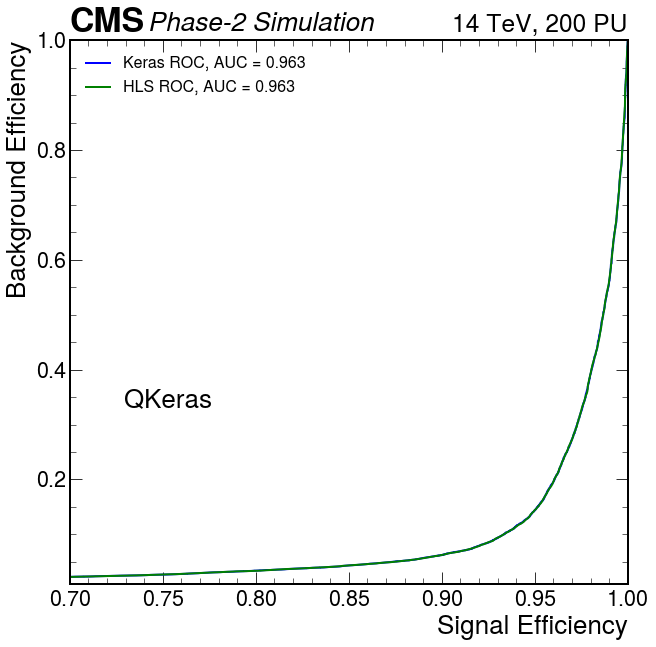

In [10]:
def plotROC(Y, y_pred, y_pred_hls4ml, label="Model"):
    
    accuracy_keras  = float(accuracy_score(np.argmax(Y,axis=1), np.argmax(y_pred,axis=1), normalize=True))
    accuracy_hls4ml = float(accuracy_score(np.argmax(Y,axis=1), np.argmax(y_pred_hls4ml,axis=1), normalize=True))

    print("Accuracy Keras:  {}".format(accuracy_keras))
    print("Accuracy hls4ml: {}".format(accuracy_hls4ml))
    
    fig, ax = plt.subplots(figsize=(10, 10))

    FPR, TPR, THR = metrics.roc_curve(Y, y_pred)
    AUC = metrics.roc_auc_score(Y, y_pred)
    
    FPR_HLS, TPR_HLS, THR_HLS = metrics.roc_curve(Y, y_pred_hls4ml)
    AUC_HLS = metrics.roc_auc_score(Y, y_pred_hls4ml)
    
    plt.plot(TPR, FPR, label='Keras ROC, AUC = %.3f' % (AUC),   color='blue',lw=2)
    plt.plot(TPR_HLS, FPR_HLS, label='HLS ROC, AUC = %.3f' % (AUC_HLS), color='green',lw=2)
    
    plt.legend(loc = 'upper left', fontsize=16)
    plt.xlabel('Signal Efficiency')
    plt.ylabel('Background Efficiency')
    mplhep.cms.label('Phase-2 Simulation', data=True, rlabel='14 TeV, 200 PU')
    plt.figtext(0.2, 0.38,label, wrap=True, horizontalalignment='left',verticalalignment='center')
    plt.ylim(0.01,1.)
    plt.xlim(0.7,1.)

# Plot the pruned floating point model:    
plotROC(Y,y_predict,y_predict_hls4ml,label="Keras") 

# Plot the pruned and quantized QKeras model
plotROC(Y,y_predict_q,y_predict_hls4ml_q,label="QKeras") 

In [11]:
synth = True
if synth:
    os.environ['PATH'] = '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
    hls_TauIdentifierModel.build(csim=False, synth=True, vsynth=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /home/llr/cms/motta/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'motta' on host 'llrai01.in2p3.fr' (Linux_x86_64 version 3.10.0-1160.49.1.el7.x86_64) on Tue Sep 20 18:54:37 CEST 2022
INFO: [HLS 200-10] On os "CentOS Linux release 7.9.2009 (Core)"
INFO: [HLS 200-10] In directory '/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/TauIdentifierModel'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSS

INFO: [HLS 200-111] Finished Standard Transforms Time (s): cpu = 00:00:29 ; elapsed = 00:00:36 . Memory (MB): peak = 1078.125 ; gain = 556.035 ; free physical = 239074 ; free virtual = 372122
INFO: [HLS 200-10] Checking synthesizability ...
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::mantissa' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:15) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::expv' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:18) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::__signbit' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.

INFO: [HLS 200-489] Unrolling loop 'ResetAccum' (firmware/nnet_utils/nnet_dense_latency.h:68) in function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config17>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'Accum1' (firmware/nnet_utils/nnet_dense_latency.h:73) in function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config17>' completely with a factor of 32.
INFO: [HLS 200-489] Unrolling loop 'Accum2' (firmware/nnet_utils/nnet_dense_latency.h:74) in function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config17>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'Result' (firmware/nnet_utils/nnet_dense_latency.h:81) in function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mod

INFO: [HLS 200-489] Unrolling loop 'Product1' (firmware/nnet_utils/nnet_conv2d_latency.h:208) in function 'nnet::conv_2d_cl<ap_fixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' completely with a factor of 12.
INFO: [HLS 200-489] Unrolling loop 'Product2' (firmware/nnet_utils/nnet_conv2d_latency.h:210) in function 'nnet::conv_2d_cl<ap_fixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'ResetAccum' (firmware/nnet_utils/nnet_conv2d_latency.h:216) in function 'nnet::conv_2d_cl<ap_fixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'Accum1' (firmware/nnet_utils/nnet_conv2d_latency.h:221) in function 'nnet::conv_2d_cl<ap_fixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3

INFO: [XFORM 203-602] Inlining function '__hls_fptosi_double_i32' into 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config20>' (firmware/nnet_utils/nnet_dense_latency.h:55) automatically.
INFO: [XFORM 203-602] Inlining function 'nnet::cast<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config20>' into 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config20>' (firmware/nnet_utils/nnet_dense_latency.h:83) automatically.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config20>'(firmware/nnet_utils/nnet_dense_latency.h:48:1) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config20>.0' at call site (firmware/nnet_utils/

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config17>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:48:27) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config17>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:46->firmware/myproject.cpp:157) by setting 'biases[15].V' to 'b17.V.15'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config14>'(firmware/nnet_utils/nnet_dense_latency.h:48:27) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config14>.0' at call site (firmware/nnet_utils/nnet_dense.h:46->firmware/myproject.cpp:136) by setting 'weights.V' to 'w1

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config14>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:48:27) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config14>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:46->firmware/myproject.cpp:136) by setting 'biases[15].V' to 'b14.V.15'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config14>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:48:27) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config14>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_d

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config14>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:48:27) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config14>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:46->firmware/myproject.cpp:136) by setting 'biases[31].V' to 'b14.V.31'.
INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config9>'(firmware/nnet_utils/nnet_batchnorm.h:67:25) to 'nnet::normalize<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config9>.0' at call site (firmware/myproject.cpp:115) by setting 'scal

INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config9>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_batchnorm.h:67:25) to 'nnet::normalize<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config9>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/myproject.cpp:115) by setting 'scale[21].V' to 's9.V.21'.
INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config9>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_batchnorm.h:67:25) to 'nnet::normalize<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config9>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/myproject.cpp:115) by setting 'scale[22].V' 

INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config9>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_batchnorm.h:67:25) to 'nnet::normalize<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config9>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/myproject.cpp:115) by setting 'bias[22].V' to 'b9.V.22'.
INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config9>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_batchnorm.h:67:25) to 'nnet::normalize<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_

INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_batchnorm.h:67:25) to 'nnet::normalize<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/myproject.cpp:80) by setting 'bias[0].V' to 'b4.V.0'.
INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_batchnorm.h:67:25) to 'nnet::normalize<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/myproject.cpp:80) by setting 'bias[1].V' to 'b4.V.1'.
INFO: [XFORM 203-622] Instantiatin

INFO: [XFORM 203-401] Performing if-conversion on hyperblock from (firmware/nnet_utils/nnet_activation.h:125:21) to (firmware/nnet_utils/nnet_activation.h:152:1) in function 'nnet::sigmoid<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, sigmoid_config22>'... converting 3 basic blocks.
INFO: [XFORM 203-401] Performing if-conversion on hyperblock from (firmware/nnet_utils/nnet_activation.h:49:20) to (firmware/nnet_utils/nnet_activation.h:56:1) in function 'nnet::linear<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, linear_config3>'... converting 2049 basic blocks.
INFO: [XFORM 203-401] Performing if-conversion on hyperblock to (firmware/nnet_utils/nnet_code_gen.h:170:5) in function 'nnet::fill_buffer_2<ap_fixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>::fill_buffer'... converting 65 basic blocks.
INFO: [XFORM 203-11] Balancing expressions in function 'nnet::fill_buffer_2<ap_fixed<16, 9,

INFO: [HLS 200-111] Finished Architecture Synthesis Time (s): cpu = 00:25:56 ; elapsed = 00:26:12 . Memory (MB): peak = 6048.082 ; gain = 5525.992 ; free physical = 236034 ; free virtual = 369104
INFO: [HLS 200-10] Starting hardware synthesis ...
INFO: [HLS 200-10] Synthesizing 'myproject' ...
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'fill_buffer_1' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'fill_buffer.1'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 2.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 1572.5 seconds; current allocated memory: 1.380 GB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource s

INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 10.82 seconds; current allocated memory: 1.631 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'pool_op_ap_fixed_16_7_0_0_0_4_0_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'pool_op<ap_fixed<16, 7, 0, 0, 0>, 4, 0>'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 1.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 10.78 seconds; current allocated memory: 1.632 GB.
INFO: [BIND 205-100] Starting micro-architecture generation ..

INFO: [SCHED 204-61] Pipelining function 'dense_latency.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 2.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 9.35 seconds; current allocated memory: 1.780 GB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Starting global binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 80.74 seconds; current allocated memory: 1.817 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'linear_ap_fixed_ap_fixed_16_6_0_0_0_linear_config15_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-1

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'myproject' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.74 seconds; current allocated memory: 1.868 GB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 91.3 seconds; current allocated memory: 1.982 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'fill_buffer_1' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-104] Estimated max fanout for 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s' is 43072 from HDL expression: ((1'b0 == ap_block_pp0_stage0) & (ap_start == 1'b1) & (1'b1 == ap_CS_fsm_pp0_stage0))
INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s'.
INFO: [HLS 200-111]  Elapsed time: 10.55 seconds; current allocated memory: 1.380 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'linear_ap_fixed_ap_fixed_16_6_0_0_0_linear_config15_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 2

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_29_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_30_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_31_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_32_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_33_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_34_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_35_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_36_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_37_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_38_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_114_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_115_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_116_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_117_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_118_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_119_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_120_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_121_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_122_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_123_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_200_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_201_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_202_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_203_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_204_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_205_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_206_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_207_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_208_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_209_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_286_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_287_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_288_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_289_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_290_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_291_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_292_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_293_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_294_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_295_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_370_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_371_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_372_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_373_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_374_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_375_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_376_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_377_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_378_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_379_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_454_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_455_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_456_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_457_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_458_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_459_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_460_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_461_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_462_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_463_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_28_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_29_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_30_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_31_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_32_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_33_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_34_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_35_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_36_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_37_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_115_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_116_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_117_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_118_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_119_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_120_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_121_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_122_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_123_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_124_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_199_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_200_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_201_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_202_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_203_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_204_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_205_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_206_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_207_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_208_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_285_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_286_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_287_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_288_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_289_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_290_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_291_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_292_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_293_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_294_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_370_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_371_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_372_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_373_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_374_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_375_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_376_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_377_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_378_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_379_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_455_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_456_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_457_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_458_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_459_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_460_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_461_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_462_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_463_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_464_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_27_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_28_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_29_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_30_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_31_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_32_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_33_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_34_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_35_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_36_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_113_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_114_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_115_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_116_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_117_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_118_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_119_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_120_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_121_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_122_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_198_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_199_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_200_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_201_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_202_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_203_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_204_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_205_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_206_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_207_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_282_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_283_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_284_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_285_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_286_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_287_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_288_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_289_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_290_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_291_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_366_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_367_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_368_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_369_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_370_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_371_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_372_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_373_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_374_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_375_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_450_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_451_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_452_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_453_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_454_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_455_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_456_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_457_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_458_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_459_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_23_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_24_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_25_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_26_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_27_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_28_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_29_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_30_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_31_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_32_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_108_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_109_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_110_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_111_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_112_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_113_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_114_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_115_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_116_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_117_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_193_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_194_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_195_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_196_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_197_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_198_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_199_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_200_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_201_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_202_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_278_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_279_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_280_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_281_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_282_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_283_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_284_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_285_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_286_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_287_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_363_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_364_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_365_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_366_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_367_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_368_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_369_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_370_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_371_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_372_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_447_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_448_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_449_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_450_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_451_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_452_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_453_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_454_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_455_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_456_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_20_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_21_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_22_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_23_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_24_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_25_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_26_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_27_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_28_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_29_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_105_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_106_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_107_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_108_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_109_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_110_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_111_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_112_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_113_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_114_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_62_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_63_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_64_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_65_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_66_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_67_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_68_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_69_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_70_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_71_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [RTMG 210-285] Implementing FIFO 'layer9_out_3_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer9_out_4_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer9_out_5_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer9_out_6_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer9_out_7_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer9_out_8_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer9_out_9_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer9_out_10_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer9_out_11_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer9_out_12_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIF

INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_17_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_18_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_19_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_20_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_21_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_22_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_23_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_24_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_25_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_26_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_30_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_31_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_32_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_33_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_34_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_35_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_36_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_37_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_38_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_39_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer15_out_9_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer15_out_10_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer15_out_11_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer15_out_12_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer15_out_13_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer15_out_14_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer15_out_15_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer15_out_16_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer15_out_17_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer15_out_18_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] 

INFO: [RTMG 210-285] Implementing FIFO 'layer18_out_13_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer18_out_14_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer18_out_15_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer19_out_0_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer19_out_1_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer19_out_2_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer19_out_3_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer19_out_4_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer19_out_5_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer19_out_6_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implem

INFO: [Synth 8-256] done synthesizing module 'linear_ap_fixed_ap_fixed_16_6_0_0_0_linear_config3_s' (3#1) [/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/TauIdentifierModel/myproject_prj/solution1/syn/vhdl/linear_ap_fixed_ap_fixed_16_6_0_0_0_linear_config3_s.vhd:1048]
INFO: [Synth 8-3491] module 'normalize_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s' declared at '/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/TauIdentifierModel/myproject_prj/solution1/syn/vhdl/normalize_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s.vhd:12' bound to instance 'normalize_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_U0' of component 'normalize_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s' [/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/TauIdentifierModel/myproject_prj/soluti

INFO: [Synth 8-256] done synthesizing module 'pooling2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config6_s' (8#1) [/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/TauIdentifierModel/myproject_prj/solution1/syn/vhdl/pooling2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config6_s.vhd:664]
INFO: [Synth 8-638] synthesizing module 'conv_2d_cl_ap_fixed_ap_fixed_16_6_5_3_0_config7_s' [/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/TauIdentifierModel/myproject_prj/solution1/syn/vhdl/conv_2d_cl_ap_fixed_ap_fixed_16_6_5_3_0_config7_s.vhd:224]
INFO: [Synth 8-5534] Detected attribute (* fsm_encoding = "none" *) [/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/TauIdentifierModel/myproject_prj/solution1/syn/vhdl/conv_2d_cl_ap_fixed_ap_fixed_16_6_5_3_0_config7_s.vhd:602]
INFO: [Synth 8-5534] Detected attribute (* fsm

	Parameter ID bound to: 1 - type: integer 
	Parameter NUM_STAGE bound to: 1 - type: integer 
	Parameter din0_WIDTH bound to: 1 - type: integer 
	Parameter din1_WIDTH bound to: 1 - type: integer 
	Parameter din2_WIDTH bound to: 1 - type: integer 
	Parameter din3_WIDTH bound to: 1 - type: integer 
	Parameter din4_WIDTH bound to: 1 - type: integer 
	Parameter din5_WIDTH bound to: 1 - type: integer 
	Parameter din6_WIDTH bound to: 1 - type: integer 
	Parameter din7_WIDTH bound to: 1 - type: integer 
	Parameter din8_WIDTH bound to: 1 - type: integer 
	Parameter din9_WIDTH bound to: 1 - type: integer 
	Parameter din10_WIDTH bound to: 1 - type: integer 
	Parameter din11_WIDTH bound to: 1 - type: integer 
	Parameter din12_WIDTH bound to: 1 - type: integer 
	Parameter din13_WIDTH bound to: 1 - type: integer 
	Parameter din14_WIDTH bound to: 1 - type: integer 
	Parameter din15_WIDTH bound to: 1 - type: integer 
	Parameter din16_WIDTH bound to: 1 - type: integer 
	Parameter din17_WIDTH bound to: 

	Parameter din109_WIDTH bound to: 1 - type: integer 
	Parameter din110_WIDTH bound to: 1 - type: integer 
	Parameter din111_WIDTH bound to: 1 - type: integer 
	Parameter din112_WIDTH bound to: 1 - type: integer 
	Parameter din113_WIDTH bound to: 1 - type: integer 
	Parameter din114_WIDTH bound to: 1 - type: integer 
	Parameter din115_WIDTH bound to: 1 - type: integer 
	Parameter din116_WIDTH bound to: 1 - type: integer 
	Parameter din117_WIDTH bound to: 1 - type: integer 
	Parameter din118_WIDTH bound to: 1 - type: integer 
	Parameter din119_WIDTH bound to: 1 - type: integer 
	Parameter din120_WIDTH bound to: 1 - type: integer 
	Parameter din121_WIDTH bound to: 1 - type: integer 
	Parameter din122_WIDTH bound to: 1 - type: integer 
	Parameter din123_WIDTH bound to: 1 - type: integer 
	Parameter din124_WIDTH bound to: 1 - type: integer 
	Parameter din125_WIDTH bound to: 1 - type: integer 
	Parameter din126_WIDTH bound to: 1 - type: integer 
	Parameter din127_WIDTH bound to: 1 - type: in

	Parameter din1_WIDTH bound to: 16 - type: integer 
	Parameter din2_WIDTH bound to: 16 - type: integer 
	Parameter din3_WIDTH bound to: 16 - type: integer 
	Parameter din4_WIDTH bound to: 16 - type: integer 
	Parameter din5_WIDTH bound to: 16 - type: integer 
	Parameter din6_WIDTH bound to: 16 - type: integer 
	Parameter din7_WIDTH bound to: 16 - type: integer 
	Parameter din8_WIDTH bound to: 16 - type: integer 
	Parameter din9_WIDTH bound to: 16 - type: integer 
	Parameter din10_WIDTH bound to: 16 - type: integer 
	Parameter din11_WIDTH bound to: 16 - type: integer 
	Parameter din12_WIDTH bound to: 16 - type: integer 
	Parameter din13_WIDTH bound to: 16 - type: integer 
	Parameter din14_WIDTH bound to: 16 - type: integer 
	Parameter din15_WIDTH bound to: 16 - type: integer 
	Parameter din16_WIDTH bound to: 16 - type: integer 
	Parameter din17_WIDTH bound to: 16 - type: integer 
	Parameter din18_WIDTH bound to: 16 - type: integer 
	Parameter din19_WIDTH bound to: 16 - type: integer 
	P

	Parameter ID bound to: 1 - type: integer 
	Parameter NUM_STAGE bound to: 1 - type: integer 
	Parameter din0_WIDTH bound to: 16 - type: integer 
	Parameter din1_WIDTH bound to: 16 - type: integer 
	Parameter din2_WIDTH bound to: 16 - type: integer 
	Parameter din3_WIDTH bound to: 16 - type: integer 
	Parameter din4_WIDTH bound to: 16 - type: integer 
	Parameter din5_WIDTH bound to: 16 - type: integer 
	Parameter din6_WIDTH bound to: 16 - type: integer 
	Parameter din7_WIDTH bound to: 16 - type: integer 
	Parameter din8_WIDTH bound to: 16 - type: integer 
	Parameter din9_WIDTH bound to: 16 - type: integer 
	Parameter din10_WIDTH bound to: 16 - type: integer 
	Parameter din11_WIDTH bound to: 16 - type: integer 
	Parameter din12_WIDTH bound to: 16 - type: integer 
	Parameter din13_WIDTH bound to: 16 - type: integer 
	Parameter din14_WIDTH bound to: 16 - type: integer 
	Parameter din15_WIDTH bound to: 16 - type: integer 
	Parameter din16_WIDTH bound to: 16 - type: integer 
	Parameter din17

	Parameter ID bound to: 1 - type: integer 
	Parameter NUM_STAGE bound to: 1 - type: integer 
	Parameter din0_WIDTH bound to: 16 - type: integer 
	Parameter din1_WIDTH bound to: 16 - type: integer 
	Parameter din2_WIDTH bound to: 16 - type: integer 
	Parameter din3_WIDTH bound to: 16 - type: integer 
	Parameter din4_WIDTH bound to: 16 - type: integer 
	Parameter din5_WIDTH bound to: 16 - type: integer 
	Parameter din6_WIDTH bound to: 16 - type: integer 
	Parameter din7_WIDTH bound to: 16 - type: integer 
	Parameter din8_WIDTH bound to: 16 - type: integer 
	Parameter din9_WIDTH bound to: 16 - type: integer 
	Parameter din10_WIDTH bound to: 16 - type: integer 
	Parameter din11_WIDTH bound to: 16 - type: integer 
	Parameter din12_WIDTH bound to: 16 - type: integer 
	Parameter din13_WIDTH bound to: 16 - type: integer 
	Parameter din14_WIDTH bound to: 16 - type: integer 
	Parameter din15_WIDTH bound to: 16 - type: integer 
	Parameter din16_WIDTH bound to: 16 - type: integer 
	Parameter din17

INFO: [Synth 8-256] done synthesizing module 'conv_2d_cl_ap_fixed_ap_fixed_16_6_5_3_0_config7_s' (14#1) [/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/TauIdentifierModel/myproject_prj/solution1/syn/vhdl/conv_2d_cl_ap_fixed_ap_fixed_16_6_5_3_0_config7_s.vhd:224]
INFO: [Synth 8-638] synthesizing module 'linear_ap_fixed_ap_fixed_16_6_0_0_0_linear_config8_s' [/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/TauIdentifierModel/myproject_prj/solution1/syn/vhdl/linear_ap_fixed_ap_fixed_16_6_0_0_0_linear_config8_s.vhd:168]
INFO: [Synth 8-5534] Detected attribute (* fsm_encoding = "none" *) [/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/TauIdentifierModel/myproject_prj/solution1/syn/vhdl/linear_ap_fixed_ap_fixed_16_6_0_0_0_linear_config8_s.vhd:177]
INFO: [Synth 8-5534] Detected attribute 

INFO: [Synth 8-256] done synthesizing module 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0' (22#1) [/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/TauIdentifierModel/myproject_prj/solution1/syn/vhdl/dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0.vhd:72]
INFO: [Synth 8-638] synthesizing module 'linear_ap_fixed_ap_fixed_16_6_0_0_0_linear_config18_s' [/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/TauIdentifierModel/myproject_prj/solution1/syn/vhdl/linear_ap_fixed_ap_fixed_16_6_0_0_0_linear_config18_s.vhd:56]
INFO: [Synth 8-5534] Detected attribute (* fsm_encoding = "none" *) [/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/TauIdentifierModel/myproject_prj/solution1/syn/vhdl/linear_ap_fixed_ap_fixed_16_6_0_0_0_linear_config18_s.vhd:65]
INFO: [Synth 8-5534] Detected attribute (* f

INFO: [Synth 8-638] synthesizing module 'fifo_w15_d2_A' [/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/TauIdentifierModel/myproject_prj/solution1/syn/vhdl/fifo_w15_d2_A.vhd:66]
	Parameter MEM_STYLE bound to: shiftreg - type: string 
	Parameter DATA_WIDTH bound to: 15 - type: integer 
	Parameter ADDR_WIDTH bound to: 1 - type: integer 
	Parameter DEPTH bound to: 2 - type: integer 
	Parameter DATA_WIDTH bound to: 15 - type: integer 
	Parameter ADDR_WIDTH bound to: 1 - type: integer 
	Parameter DEPTH bound to: 2 - type: integer 
INFO: [Synth 8-638] synthesizing module 'fifo_w15_d2_A_shiftReg' [/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/TauIdentifierModel/myproject_prj/solution1/syn/vhdl/fifo_w15_d2_A.vhd:23]
	Parameter DATA_WIDTH bound to: 15 - type: integer 
	Parameter ADDR_WIDTH bound to: 1 - type: integer 
	Parameter DEPTH bound to: 2 - type: i

Hierarchical RTL Component report 
Module myproject 
Detailed RTL Component Info : 
+---XORs : 
	   2 Input      1 Bit         XORs := 5366  
+---Registers : 
	                1 Bit    Registers := 2682  
+---Muxes : 
	   2 Input      1 Bit        Muxes := 16    
Module fill_buffer_1 
Detailed RTL Component Info : 
+---Registers : 
	             2160 Bit    Registers := 1     
	               16 Bit    Registers := 33    
	                1 Bit    Registers := 2     
+---Muxes : 
	   2 Input     16 Bit        Muxes := 24    
	   2 Input      1 Bit        Muxes := 63    
Module conv_2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config2_2170 
Detailed RTL Component Info : 
+---Adders : 
	   3 Input     23 Bit       Adders := 12    
	   2 Input     23 Bit       Adders := 2     
	   2 Input     22 Bit       Adders := 10    
	   3 Input     22 Bit       Adders := 10    
	   3 Input     21 Bit       Adders := 10    
	   2 Input     21 Bit       Adders := 4     
	   3 Input     20 Bit       Adders := 14

	                2 Bit    Registers := 1     
	                1 Bit    Registers := 2     
+---Muxes : 
	   2 Input      1 Bit        Muxes := 3     
Module fifo_w16_d2_A_shiftReg__991 
Detailed RTL Component Info : 
+---Registers : 
	               16 Bit    Registers := 2     
+---Muxes : 
	   2 Input     16 Bit        Muxes := 1     
Module fifo_w16_d2_A__991 
Detailed RTL Component Info : 
+---Adders : 
	   2 Input      2 Bit       Adders := 1     
+---Registers : 
	                2 Bit    Registers := 1     
	                1 Bit    Registers := 2     
+---Muxes : 
	   2 Input      1 Bit        Muxes := 3     
Module fifo_w16_d2_A_shiftReg__992 
Detailed RTL Component Info : 
+---Registers : 
	               16 Bit    Registers := 2     
+---Muxes : 
	   2 Input     16 Bit        Muxes := 1     
Module fifo_w16_d2_A__992 
Detailed RTL Component Info : 
+---Adders : 
	   2 Input      2 Bit       Adders := 1     
+---Registers : 
	                2 Bit    Registers := 1     
	   

Module fifo_w16_d2_A__1759 
Detailed RTL Component Info : 
+---Adders : 
	   2 Input      2 Bit       Adders := 1     
+---Registers : 
	                2 Bit    Registers := 1     
	                1 Bit    Registers := 2     
+---Muxes : 
	   2 Input      1 Bit        Muxes := 3     
Module fifo_w16_d2_A_shiftReg__1760 
Detailed RTL Component Info : 
+---Registers : 
	               16 Bit    Registers := 2     
+---Muxes : 
	   2 Input     16 Bit        Muxes := 1     
Module fifo_w16_d2_A__1760 
Detailed RTL Component Info : 
+---Adders : 
	   2 Input      2 Bit       Adders := 1     
+---Registers : 
	                2 Bit    Registers := 1     
	                1 Bit    Registers := 2     
+---Muxes : 
	   2 Input      1 Bit        Muxes := 3     
Module fifo_w16_d2_A_shiftReg__1761 
Detailed RTL Component Info : 
+---Registers : 
	               16 Bit    Registers := 2     
+---Muxes : 
	   2 Input     16 Bit        Muxes := 1     
Module fifo_w16_d2_A__1761 
Detailed RTL Compo

No constraint files found.
---------------------------------------------------------------------------------
Start Cross Boundary and Area Optimization
---------------------------------------------------------------------------------
DSP Report: Generating DSP mul_ln1118_2880_fu_4040_p2, operation Mode is: A*(B:0x3ff91).
DSP Report: operator mul_ln1118_2880_fu_4040_p2 is absorbed into DSP mul_ln1118_2880_fu_4040_p2.
DSP Report: Generating DSP mul_ln1118_2648_fu_4480_p2, operation Mode is: A*(B:0x3ffd2).
DSP Report: operator mul_ln1118_2648_fu_4480_p2 is absorbed into DSP mul_ln1118_2648_fu_4480_p2.
DSP Report: Generating DSP mul_ln1118_2757_fu_3844_p2, operation Mode is: A*(B:0x3ffdb).
DSP Report: operator mul_ln1118_2757_fu_3844_p2 is absorbed into DSP mul_ln1118_2757_fu_3844_p2.
DSP Report: Generating DSP mul_ln1118_2565_fu_4273_p2, operation Mode is: A*(B:0x23).
DSP Report: operator mul_ln1118_2565_fu_4273_p2 is absorbed into DSP mul_ln1118_2565_fu_4273_p2.
DSP Report: Generating DS

DSP Report: Generating DSP mul_ln1118_2686_fu_5186_p2, operation Mode is: A*(B:0x2b).
DSP Report: operator mul_ln1118_2686_fu_5186_p2 is absorbed into DSP mul_ln1118_2686_fu_5186_p2.
DSP Report: Generating DSP mul_ln1118_2594_fu_4615_p2, operation Mode is: A*(B:0x3d).
DSP Report: operator mul_ln1118_2594_fu_4615_p2 is absorbed into DSP mul_ln1118_2594_fu_4615_p2.
DSP Report: Generating DSP mul_ln1118_3023_fu_4223_p2, operation Mode is: A*(B:0x3a).
DSP Report: operator mul_ln1118_3023_fu_4223_p2 is absorbed into DSP mul_ln1118_3023_fu_4223_p2.
DSP Report: Generating DSP mul_ln1118_3113_fu_4436_p2, operation Mode is: A*(B:0x3ffc6).
DSP Report: operator mul_ln1118_3113_fu_4436_p2 is absorbed into DSP mul_ln1118_3113_fu_4436_p2.
DSP Report: Generating DSP mul_ln1118_2340_fu_5331_p2, operation Mode is: A*(B:0x3ffcc).
DSP Report: operator mul_ln1118_2340_fu_5331_p2 is absorbed into DSP mul_ln1118_2340_fu_5331_p2.
DSP Report: Generating DSP mul_ln1118_2416_fu_4733_p2, operation Mode is: A*(B:

DSP Report: Generating DSP mul_ln1118_1208_fu_2393_p2, operation Mode is: A*(B:0xc6).
DSP Report: operator mul_ln1118_1208_fu_2393_p2 is absorbed into DSP mul_ln1118_1208_fu_2393_p2.
DSP Report: Generating DSP mul_ln1118_1111_fu_3567_p2, operation Mode is: A*(B:0xb3).
DSP Report: operator mul_ln1118_1111_fu_3567_p2 is absorbed into DSP mul_ln1118_1111_fu_3567_p2.
DSP Report: Generating DSP mul_ln1118_1161_fu_3111_p2, operation Mode is: A*(B:0x9a).
DSP Report: operator mul_ln1118_1161_fu_3111_p2 is absorbed into DSP mul_ln1118_1161_fu_3111_p2.
DSP Report: Generating DSP mul_ln1118_968_fu_4016_p2, operation Mode is: A*(B:0xb3).
DSP Report: operator mul_ln1118_968_fu_4016_p2 is absorbed into DSP mul_ln1118_968_fu_4016_p2.
DSP Report: Generating DSP mul_ln1118_827_fu_2659_p2, operation Mode is: A*(B:0x3ff32).
DSP Report: operator mul_ln1118_827_fu_2659_p2 is absorbed into DSP mul_ln1118_827_fu_2659_p2.
DSP Report: Generating DSP mul_ln1118_1137_fu_3957_p2, operation Mode is: A*(B:0x3ff51).

DSP Report: Generating DSP mul_ln1118_1638_fu_2121_p2, operation Mode is: A*(B:0x3ff11).
DSP Report: operator mul_ln1118_1638_fu_2121_p2 is absorbed into DSP mul_ln1118_1638_fu_2121_p2.
DSP Report: Generating DSP mul_ln1118_681_fu_4285_p2, operation Mode is: A*(B:0x3ffb5).
DSP Report: operator mul_ln1118_681_fu_4285_p2 is absorbed into DSP mul_ln1118_681_fu_4285_p2.
DSP Report: Generating DSP mul_ln1118_655_fu_3724_p2, operation Mode is: A*(B:0x55).
DSP Report: operator mul_ln1118_655_fu_3724_p2 is absorbed into DSP mul_ln1118_655_fu_3724_p2.
DSP Report: Generating DSP mul_ln1118_1449_fu_3591_p2, operation Mode is: A*(B:0x2f).
DSP Report: operator mul_ln1118_1449_fu_3591_p2 is absorbed into DSP mul_ln1118_1449_fu_3591_p2.
DSP Report: Generating DSP mul_ln1118_1498_fu_2900_p2, operation Mode is: A*(B:0x3ffd3).
DSP Report: operator mul_ln1118_1498_fu_2900_p2 is absorbed into DSP mul_ln1118_1498_fu_2900_p2.
DSP Report: Generating DSP mul_ln1118_1501_fu_2676_p2, operation Mode is: A*(B:0x3

DSP Report: Generating DSP mul_ln1118_1662_fu_2332_p2, operation Mode is: A*(B:0x46).
DSP Report: operator mul_ln1118_1662_fu_2332_p2 is absorbed into DSP mul_ln1118_1662_fu_2332_p2.
DSP Report: Generating DSP mul_ln1118_1688_fu_3714_p2, operation Mode is: A*(B:0x3ffb2).
DSP Report: operator mul_ln1118_1688_fu_3714_p2 is absorbed into DSP mul_ln1118_1688_fu_3714_p2.
DSP Report: Generating DSP mul_ln1118_1736_fu_3322_p2, operation Mode is: A*(B:0x5d).
DSP Report: operator mul_ln1118_1736_fu_3322_p2 is absorbed into DSP mul_ln1118_1736_fu_3322_p2.
DSP Report: Generating DSP mul_ln1118_68_fu_3204_p2, operation Mode is: A*(B:0x32).
DSP Report: operator mul_ln1118_68_fu_3204_p2 is absorbed into DSP mul_ln1118_68_fu_3204_p2.
DSP Report: Generating DSP mul_ln1118_1363_fu_2589_p2, operation Mode is: A*(B:0x3ffd5).
DSP Report: operator mul_ln1118_1363_fu_2589_p2 is absorbed into DSP mul_ln1118_1363_fu_2589_p2.
DSP Report: Generating DSP mul_ln1118_1368_fu_2968_p2, operation Mode is: A*(B:0x3ffc

DSP Report: Generating DSP mul_ln1118_1873_fu_1256_p2, operation Mode is: A*(B:0x1b).
DSP Report: operator mul_ln1118_1873_fu_1256_p2 is absorbed into DSP mul_ln1118_1873_fu_1256_p2.
DSP Report: Generating DSP mul_ln1118_1887_fu_1450_p2, operation Mode is: A*(B:0x105).
DSP Report: operator mul_ln1118_1887_fu_1450_p2 is absorbed into DSP mul_ln1118_1887_fu_1450_p2.
DSP Report: Generating DSP mul_ln1118_2187_fu_1510_p2, operation Mode is: A*(B:0x3ff91).
DSP Report: operator mul_ln1118_2187_fu_1510_p2 is absorbed into DSP mul_ln1118_2187_fu_1510_p2.
DSP Report: Generating DSP mul_ln1118_2200_fu_1282_p2, operation Mode is: A*(B:0x3ff89).
DSP Report: operator mul_ln1118_2200_fu_1282_p2 is absorbed into DSP mul_ln1118_2200_fu_1282_p2.
DSP Report: Generating DSP mul_ln1118_1847_fu_1266_p2, operation Mode is: A*(B:0x3ffa8).
DSP Report: operator mul_ln1118_1847_fu_1266_p2 is absorbed into DSP mul_ln1118_1847_fu_1266_p2.
DSP Report: Generating DSP mul_ln1118_2226_fu_1394_p2, operation Mode is: A

INFO: [Synth 8-3333] propagating constant 1 across sequential element (\ap_CS_fsm_reg[0] )
INFO: [Synth 8-3333] propagating constant 1 across sequential element (\ap_CS_fsm_reg[0] )
INFO: [Synth 8-3886] merging instance 'p_067_i_idx1_814_t_i_i_reg_144220_reg[2]' (FDE) to 'p_067_i_idx1_915_t_i_i_reg_144410_reg[2]'
INFO: [Synth 8-3886] merging instance 'p_067_i_idx1_814_t_i_i_reg_144220_reg[0]' (FDE) to 'p_067_i_idx1_28_t_i_i_reg_143286_reg[0]'
INFO: [Synth 8-3886] merging instance 'p_067_i_idx1_814_t_i_i_reg_144220_reg[6]' (FDE) to 'p_067_i_idx1_915_t_i_i_reg_144410_reg[6]'
INFO: [Synth 8-3886] merging instance 'p_067_i_idx1_814_t_i_i_reg_144220_reg[1]' (FDE) to 'p_067_i_idx1_915_t_i_i_reg_144410_reg[1]'
INFO: [Synth 8-3886] merging instance 'p_067_i_idx1_814_t_i_i_reg_144220_reg[4]' (FDE) to 'p_067_i_idx1_915_t_i_i_reg_144410_reg[4]'
INFO: [Synth 8-3886] merging instance 'p_067_i_idx1_814_t_i_i_reg_144220_reg[7]' (FDE) to 'p_067_i_idx1_915_t_i_i_reg_144410_reg[7]'
INFO: [Synth 8-3886] 

---------------------------------------------------------------------------------
Finished Cross Boundary and Area Optimization : Time (s): cpu = 00:05:37 ; elapsed = 00:05:48 . Memory (MB): peak = 4507.062 ; gain = 2866.449 ; free physical = 220812 ; free virtual = 356053
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start ROM, RAM, DSP and Shift Register Reporting
---------------------------------------------------------------------------------

DSP: Preliminary Mapping	Report (see note below)
+--------------------------------------------------------------+--------------------------------+--------+--------+--------+--------+--------+------+------+------+------+-------+------+------+
|Module Name                                                   | DSP Mapping                    | A Size | B Size | C Size | D Size | P Size | AREG | BREG | CREG | DREG | ADREG | MREG | PR


Report RTL Partitions: 
+------+--------------------------------------------------------------------+------------+----------+
|      |RTL Partition                                                       |Replication |Instances |
+------+--------------------------------------------------------------------+------------+----------+
|1     |conv_2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config2_2170__GB0           |           1|      7735|
|2     |conv_2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config2_2170__GB1           |           1|      3494|
|3     |conv_2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config2_2170__GB2           |           1|      2893|
|4     |conv_2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config2_2170__GB3           |           1|      3362|
|5     |conv_2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config2_2170__GB4           |           1|      4327|
|6     |conv_2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config2_2170__GB5           |           1|      3986|
|7     |conv_2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config2_2

---------------------------------------------------------------------------------
Finished Timing Optimization : Time (s): cpu = 00:06:08 ; elapsed = 00:06:21 . Memory (MB): peak = 4507.062 ; gain = 2866.449 ; free physical = 220565 ; free virtual = 356099
---------------------------------------------------------------------------------

Report RTL Partitions: 
+------+--------------------------------------------------------------------+------------+----------+
|      |RTL Partition                                                       |Replication |Instances |
+------+--------------------------------------------------------------------+------------+----------+
|1     |conv_2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config2_2170__GB0           |           1|      7583|
|2     |conv_2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config2_2170__GB1           |           1|      3449|
|3     |conv_2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config2_2170__GB2           |           1|      2893|
|4     |conv_2d_cl_ap_fi

---------------------------------------------------------------------------------
Finished Technology Mapping : Time (s): cpu = 00:06:56 ; elapsed = 00:07:12 . Memory (MB): peak = 4575.527 ; gain = 2934.914 ; free physical = 220557 ; free virtual = 356110
---------------------------------------------------------------------------------

Report RTL Partitions: 
+------+--------------------------------------------------------------------+------------+----------+
|      |RTL Partition                                                       |Replication |Instances |
+------+--------------------------------------------------------------------+------------+----------+
|1     |conv_2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config2_2170__GB0           |           1|      5424|
|2     |conv_2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config2_2170__GB1           |           1|      2302|
|3     |conv_2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config2_2170__GB2           |           1|      2047|
|4     |conv_2d_cl_ap_fix

---------------------------------------------------------------------------------
Finished Flattening Before IO Insertion
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Final Netlist Cleanup
---------------------------------------------------------------------------------
INFO: [Synth 8-7053] The timing for the instance sigmoid_ap_fixed_ap_fixed_sigmoid_config22_U0/sigmoid_table1_U/sigmoid_ap_fixed_ap_fixed_sigmoid_config22_s_sigmoid_table1_rom_U/q0_reg (implemented as a Block RAM) might be sub-optimal as no optional output register could be merged into the ram block. Providing additional output register may help in improving timing.
INFO: [Synth 8-6064] Net n_0_216774 is driving 105 big block pins (URAM, BRAM and DSP loads). Created 11 replicas of its driver. 
INFO: [Synth 8-6064] Net n_0_216817 is driving 120 big block pins (URAM, BRAM and DSP loads). Created 12 

---------------------------------------------------------------------------------
Finished Final Netlist Cleanup
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished IO Insertion : Time (s): cpu = 00:08:02 ; elapsed = 00:08:21 . Memory (MB): peak = 4819.273 ; gain = 3178.660 ; free physical = 220326 ; free virtual = 356101
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Renaming Generated Instances
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Renaming Generated Instances : Time (s): cpu = 00:08:03 ; elapsed = 00:08:22 . Memory (MB): peak = 4819.273 ; gain = 3178.660 ; free physical = 220331 ; free virtual = 356105
--------

|4253  |    U_fifo_w15_d2_A_shiftReg                                            |fifo_w15_d2_A_shiftReg_3250                                     |     54|
|4254  |  layer5_out_358_V_U                                                    |fifo_w15_d2_A_2112                                              |     74|
|4255  |    U_fifo_w15_d2_A_shiftReg                                            |fifo_w15_d2_A_shiftReg_3249                                     |     54|
|4256  |  layer5_out_359_V_U                                                    |fifo_w15_d2_A_2113                                              |     66|
|4257  |    U_fifo_w15_d2_A_shiftReg                                            |fifo_w15_d2_A_shiftReg_3248                                     |     54|
|4258  |  layer5_out_35_V_U                                                     |fifo_w15_d2_A_2114                                              |     66|
|4259  |    U_fifo_w15_d2_A_shiftReg                                  

Synthesis Optimization Runtime : Time (s): cpu = 00:10:40 ; elapsed = 00:11:03 . Memory (MB): peak = 4823.180 ; gain = 3182.566 ; free physical = 226968 ; free virtual = 362749
Synthesis Optimization Complete : Time (s): cpu = 00:10:40 ; elapsed = 00:11:03 . Memory (MB): peak = 4823.180 ; gain = 3182.566 ; free physical = 227000 ; free virtual = 362749
INFO: [Project 1-571] Translating synthesized netlist
Netlist sorting complete. Time (s): cpu = 00:00:05 ; elapsed = 00:00:05 . Memory (MB): peak = 4823.180 ; gain = 0.000 ; free physical = 226596 ; free virtual = 362345
INFO: [Netlist 29-17] Analyzing 15970 Unisim elements for replacement
INFO: [Netlist 29-28] Unisim Transformation completed in 26 CPU seconds
INFO: [Project 1-570] Preparing netlist for logic optimization
INFO: [Opt 31-138] Pushed 0 inverter(s) to 0 load pin(s).
Netlist sorting complete. Time (s): cpu = 00:00:00.08 ; elapsed = 00:00:00.08 . Memory (MB): peak = 5566.988 ; gain = 0.000 ; free physical = 225567 ; free virtu

In [14]:
synth = True
if synth:
    os.environ['PATH'] = '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
    hls_TauQIdentifierModel.build(csim=False, synth=True, vsynth=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /home/llr/cms/motta/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'motta' on host 'llrai01.in2p3.fr' (Linux_x86_64 version 3.10.0-1160.49.1.el7.x86_64) on Mon Sep 19 15:33:25 CEST 2022
INFO: [HLS 200-10] On os "CentOS Linux release 7.9.2009 (Core)"
INFO: [HLS 200-10] In directory '/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/TauQIdentifierModel'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMS